In [1]:
from fit.datamodules.tomo_rec.TRecDataModule import CropLoDoPaBFourierTargetDataModule
from fit.utils import convert2FC, fft_interpolate, psfft, convert_to_dft, PSNR
from fit.utils.tomo_utils import get_proj_coords_pol, get_img_coords_pol
from matplotlib import pyplot as plt

import torch

import numpy as np

from skimage.transform import iradon

from fit.utils.utils import denormalize, PSNR

from fit.modules import TRecTransformerModule

from matplotlib import gridspec

from tqdm import tqdm_notebook as tqdm

In [2]:
batch_size = 1
num_angles = 33
img_shape = 111
inner_circle = True

In [3]:
n = 8

In [4]:
imgs = []
sinos = []

In [5]:
dm = CropLoDoPaBFourierTargetDataModule(batch_size=batch_size, gt_shape=img_shape, num_angles=num_angles)
dm.setup()

test_dl = dm.test_dataloader()

i = 0
for sino, img  in test_dl.dataset.ds:
    imgs.append(img)
    sinos.append(sino)
    if i > n:
        break
    i += 1

In [6]:
x, y = torch.meshgrid(torch.arange(-img_shape // 2 + 1,
                                    img_shape // 2 + 1),
                              torch.arange(-img_shape // 2 + 1,
                                           img_shape // 2 + 1))
circle = torch.sqrt(x ** 2. + y ** 2.) <= img_shape // 2

In [7]:
test_dl = dm.test_dataloader()

fbp_psnrs = []
for i in tqdm(range(len(test_dl.dataset.ds))):
    sino, img = test_dl.dataset.ds[i]
    rec = torch.from_numpy(np.array(iradon(sino.numpy().T, theta=-np.rad2deg(dm.gt_ds.get_ray_trafo().geometry.angles)).T))
    img = denormalize(img, dm.mean, dm.std)
    rec = denormalize(rec, dm.mean, dm.std)
    rec *= circle
    img *= circle
    fbp_psnrs.append(PSNR(img, rec, img.max() - img.min()))

/home/tbuchhol/Programs/miniconda3/envs/ft/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [8]:
np.round(torch.mean(torch.stack(fbp_psnrs)).item(), 2)

26.620000000000001

In [9]:
dm = CropLoDoPaBFourierTargetDataModule(batch_size=8, gt_shape=img_shape, num_angles=num_angles)
dm.setup()

In [10]:
test_dl = dm.test_dataloader()

# x and y are normalized magnitude and angle of the Fourier coefficients
i = 0
x_ = []
fbp_ = []
y_ = []
y_real_ = []
for x, fbp, y, y_real, (mag_min, mag_max) in test_dl:
    x_.append(x)
    fbp_.append(fbp)
    y_.append(y)
    y_real_.append(y_real)
    if i > n:
        break
        
    i += 1

In [11]:
x = torch.cat(x_)
fbp = torch.cat(fbp_)
y = torch.cat(y_)
y_real = torch.cat(y_real_)

In [12]:
x.shape

torch.Size([10, 1848, 2])

In [13]:
x_fc = convert2FC(x, mag_min, mag_max)
fbp_fc = convert2FC(fbp, mag_min, mag_max)
y_fc = convert2FC(y, mag_min, mag_max)

In [14]:
det_len = dm.gt_ds.get_ray_trafo().geometry.detector.shape[0]

In [15]:
srcx, srcy, src_flatten_order = get_proj_coords_pol(angles=dm.gt_ds.get_ray_trafo().geometry.angles, 
                                                          det_len=det_len)
dstx, dsty, dst_flatten_order, order = get_img_coords_pol(img_shape=img_shape, det_len=det_len)

In [16]:
x_fc.shape

torch.Size([10, 1848])

In [17]:
from fit.utils.tomo_utils import pol2cart

In [18]:
def get_imgs(path, x, fbp, y, eo=False):
    model = TRecTransformerModule.load_from_checkpoint(path, 
                               y_coords_proj=srcx,
                               x_coords_proj=srcy,
                               y_coords_img=dstx,
                               x_coords_img=dsty,
                               angles=dm.gt_ds.get_ray_trafo().geometry.angles,
                               src_flatten_coords=src_flatten_order,
                               dst_flatten_coords=dst_flatten_order,
                               dst_order=order,
                               encoder_only=eo)
        

    model.bin_factor = 1

    x_fc_, fbp_fc_, y_fc_ = model._bin_data(x, fbp, y)

    pred_fc, pred_img = model.trec.forward(x_fc_, fbp_fc_, mag_min=mag_min, mag_max=mag_max,
                                    dst_flatten_coords=model.dst_flatten_coords,
                                    img_shape=model.hparams.img_shape,
                                    attenuation=model.mask)

    tmp = convert2FC(pred_fc, mag_min, mag_max)
    pred_fc_ = torch.ones(x.shape[0], img_shape * (img_shape // 2 + 1), dtype=x.dtype, device=x.device)
    pred_fc_[:,:tmp.shape[1]] = tmp

    dft_pred_fc = convert_to_dft(fc=pred_fc, mag_min=mag_min, mag_max=mag_max,
                                        dst_flatten_coords=model.dst_flatten_coords, img_shape=model.hparams.img_shape)
#     dft_pred_fc *= model.mask
    img_pred_fc = torch.roll(torch.fft.irfftn(dft_pred_fc, dim=[1, 2], s=2 * (model.hparams.img_shape,)),
                          2 * (model.hparams.img_shape // 2,), (1, 2))
    
    return img_pred_fc, pred_img

In [19]:
path_normal = '/home/tbuchhol/HaarVAE/FIT_experiments/iccv_experiments/TRec/trec_LoDoPaBCrop111_v0.1.21_fbp_prod_nh8_dq32_icTrue_ibf8_bfc5_nl4_me350_ta33_pc/lightning_logs/version_39331879/checkpoints/best_val_loss_-epoch=54-step=54999.ckpt'
path_FQP = '/home/tbuchhol/HaarVAE/FIT_experiments/iccv_experiments/TRec/trec_LoDoPaBCrop111_v0.1.21_prod_nh8_dq32_icTrue_ibf8_bfc5_nl4_me350_ta33_pc/lightning_logs/version_39332465/checkpoints/best_val_loss_-epoch=228-step=228999.ckpt'
path_EO = '/home/tbuchhol/HaarVAE/FIT_experiments/iccv_experiments/TRec/trec_LoDoPaBCrop111_v0.1.21_eo_fbp_prod_nh8_dq32_icTrue_ibf8_bfc5_nl4_me350_ta33_pc/lightning_logs/version_39351252/checkpoints/best_val_loss_-epoch=33-step=33999.ckpt'

In [20]:
normal_fc_pred, normal_pred = get_imgs(path_normal, x, fbp, y)

/home/tbuchhol/.local/lib/python3.7/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/tbuchhol/Programs/miniconda3/envs/ft/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /pytorch/aten/src/ATen/native/Copy.cpp:162.)


In [21]:
FQP_fc_pred, FQP_pred = get_imgs(path_FQP, x, fbp, y)

In [22]:
EO_fc_pred, EO_pred = get_imgs(path_EO, x, fbp, y, eo=True)

In [23]:
fbp_imgs = [torch.from_numpy(np.array(iradon(sino.T, theta=-np.rad2deg(dm.gt_ds.get_ray_trafo().geometry.angles)).T)) for sino in sinos]

In [24]:
from fig_utils import figure

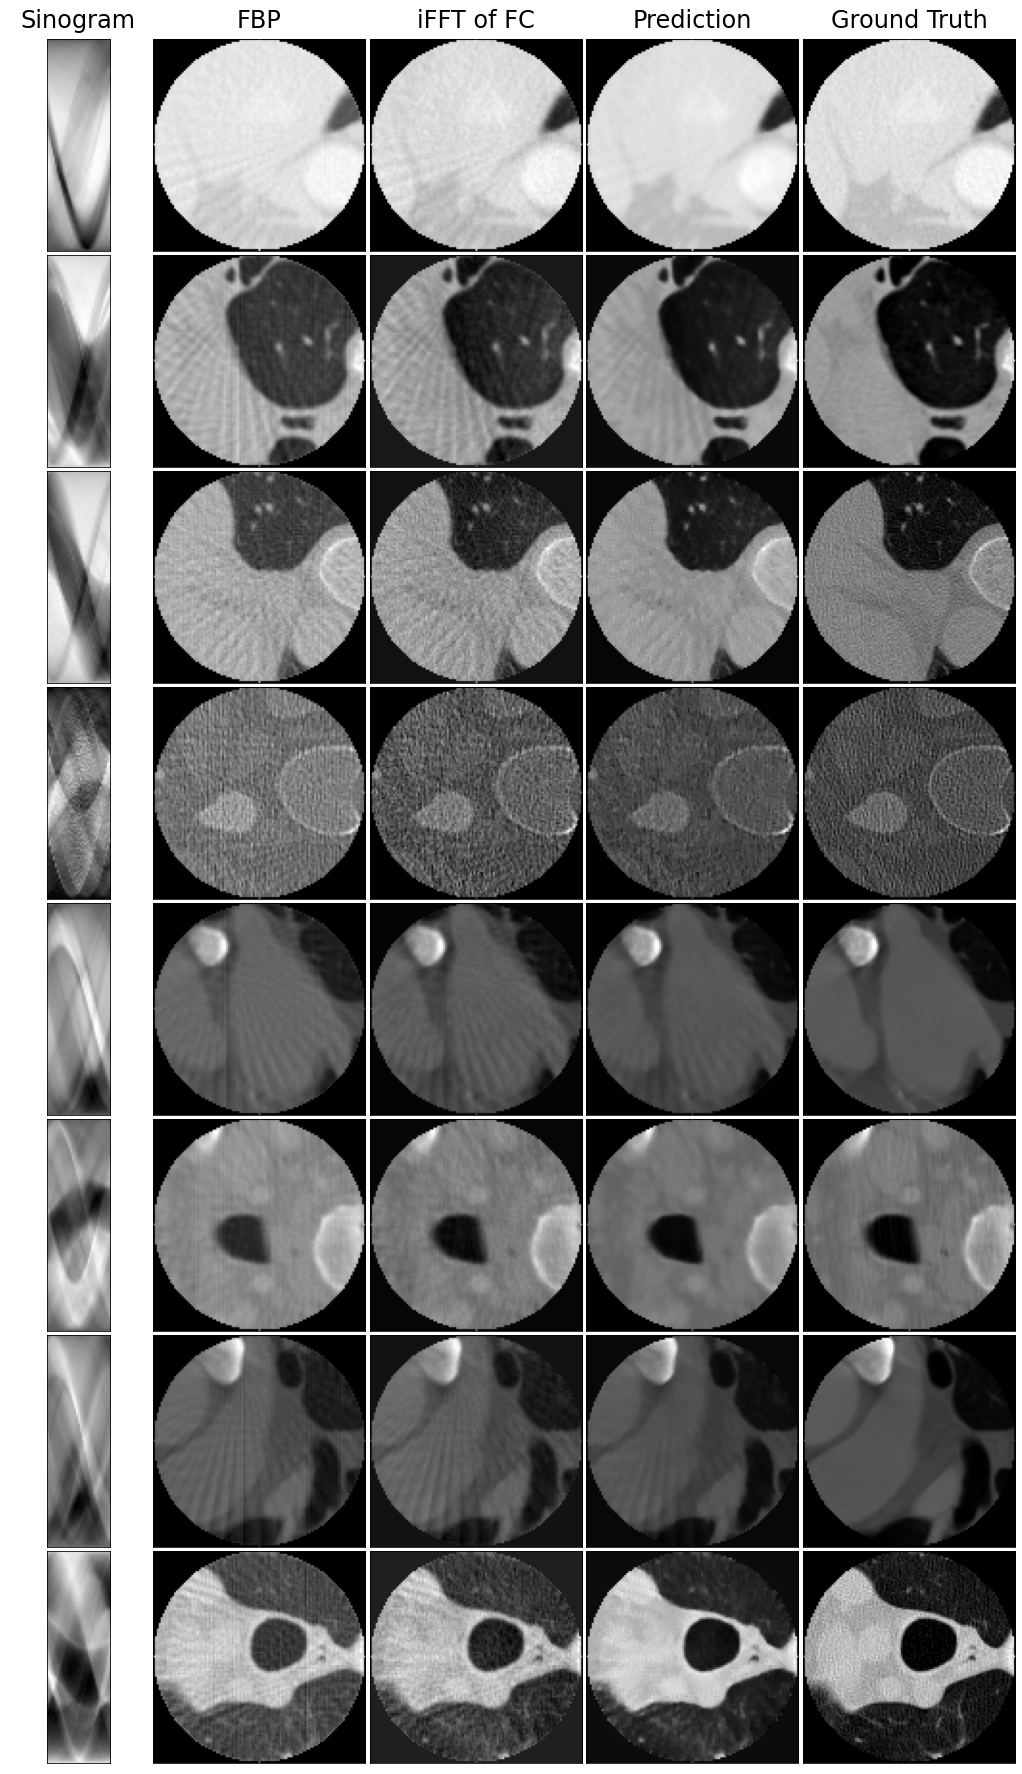

In [25]:
figure(name='trec_lodopabcrop_ta33_normal_quali.pdf', 
       sinos=sinos, 
       fbp_imgs=fbp_imgs, 
       img_pred_fc=normal_fc_pred, 
       pred_img=normal_pred, 
       imgs=imgs,
       mean=dm.mean,
       std=dm.std,
       circle=circle)

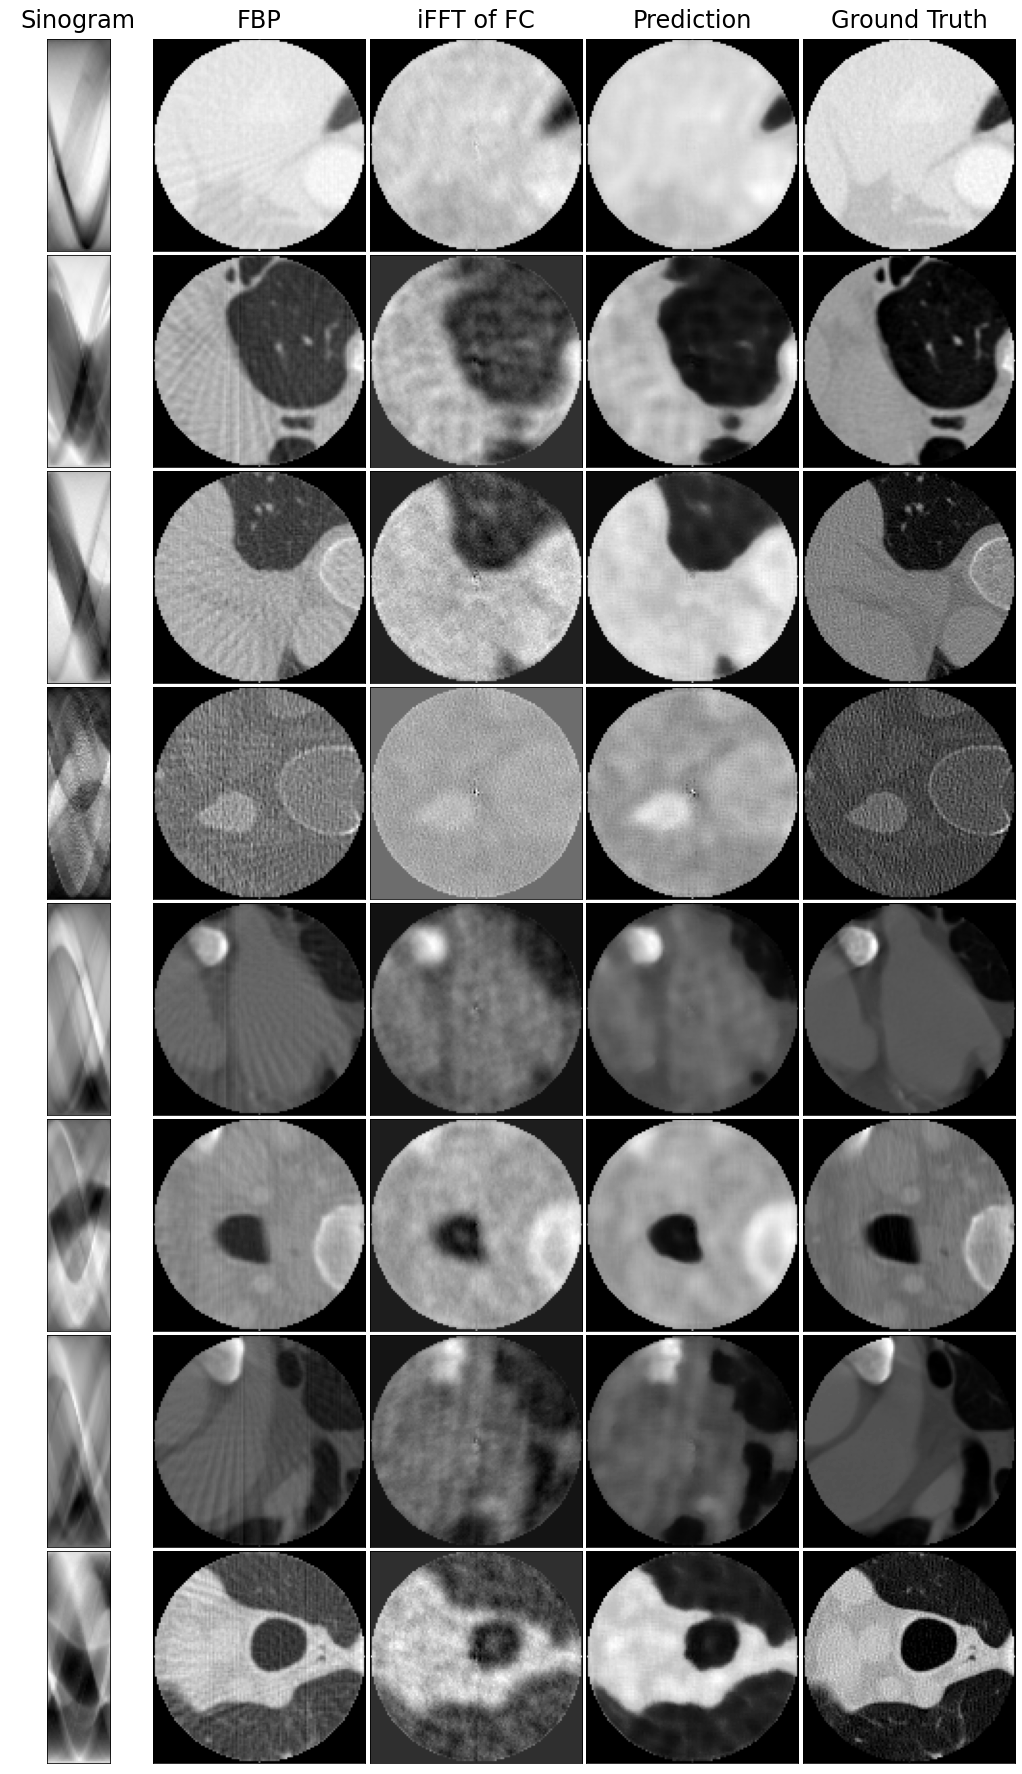

In [26]:
figure(name='trec_lodopabcrop_ta33_fqp_quali.pdf', 
       sinos=sinos, 
       fbp_imgs=fbp_imgs, 
       img_pred_fc=FQP_fc_pred, 
       pred_img=FQP_pred, 
       imgs=imgs,
       mean=dm.mean,
       std=dm.std,
       circle=circle)

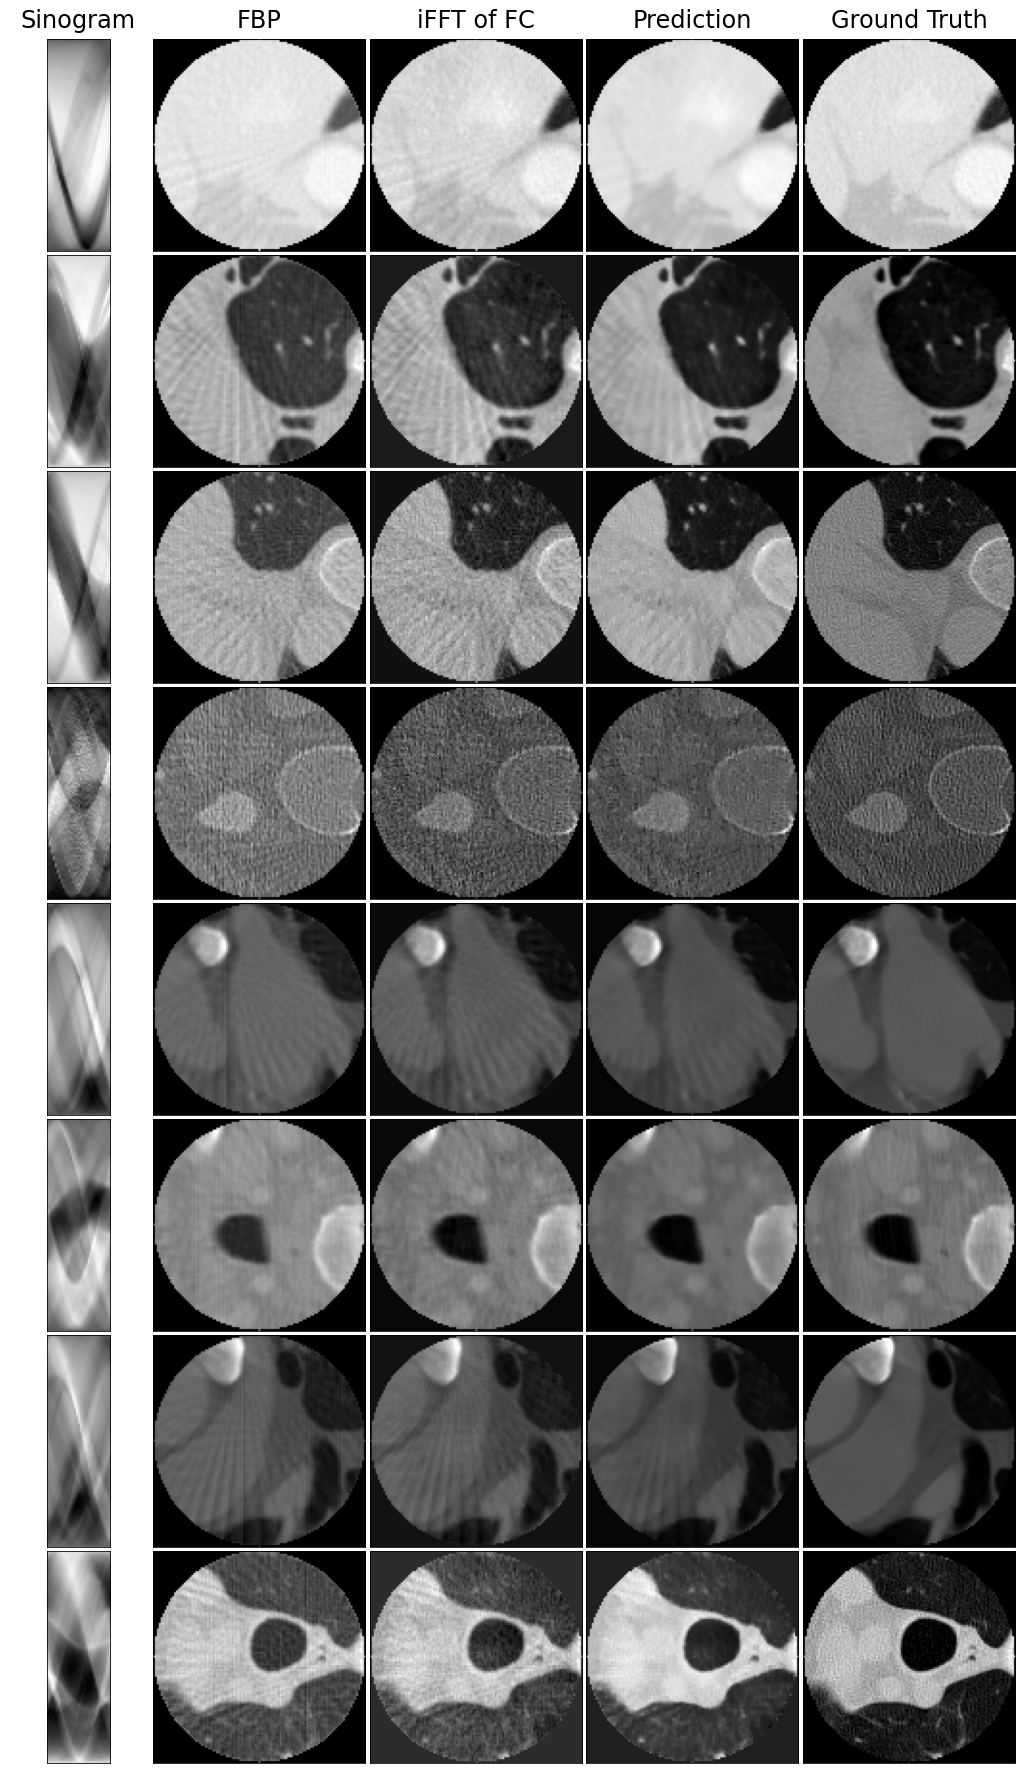

In [27]:
figure(name='trec_lodopabcrop_ta33_eo_quali.pdf', 
       sinos=sinos, 
       fbp_imgs=fbp_imgs, 
       img_pred_fc=EO_fc_pred, 
       pred_img=EO_pred, 
       imgs=imgs,
       mean=dm.mean,
       std=dm.std,
       circle=circle)